## <font color=green>Overview</font>

This analysis uses the Kaggle's World Suicide Data from 1985 to 2016, so we can get a wide panorama of what are the main factors for high suicide rates and also, how is the situation around the world. For that, we can raise a couple of initial questions to auxiliate in the analysis.

- Do Women and Men have similar rates of suicide?
- The Suicide rate is really increasing over the generations?
- What do the top 20 countries have in common?
- GDP have an impact on suicide rates?
- How is the situation in South America?
- What are some relevant factors for suicide?



***

## <font color=green>Libs</font>

For this case, we are going to use a couple of libaries to auxiliate in the process:

- __Pandas & Numpy:__ To Read and Transform data in our Dataset.
- __Matplotlib & Seaborn:__ For Dataviz.
- __Pycountry & Geopandas:__ To help on gather other data so we can join with our dataset and get more accurate analysis, such as continent, location and coordinates for map plotting.
- __Scipy:__ Specific the stats module for basic regressions and correlation ploting.


In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pycountry
import geopandas
from scipy import stats

%matplotlib inline 
sns.set(color_codes=True)

***
## <font color=green>DataLoad</font>


In [3]:

df = pd.read_csv('data.csv')

df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


***
## <font color=green>Data Cleaning</font>

In [5]:
# Let's rename columns so they can be more intuitive and also dont include some unnecesary characters such as () and $
df.rename(columns={"suicides/100k pop":"suicides_pop","HDI for year":"HDI_for_year",
                  " gdp_for_year ($) ":"gdp_for_year"," gdp_per_capita ($)":"gdp_per_capita",
                    "gdp_per_capita ($)":"gdp_per_capita"}, inplace=True)
print(df.columns)

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides_pop', 'country-year', 'HDI_for_year', 'gdp_for_year',
       'gdp_per_capita', 'generation'],
      dtype='object')


In [6]:
#Creating Function to substitute ',' for '.' its gonna be mainly used on gdp_for_year column

def substitute_comma(dataframe,column):
    dataframe[column] = df[column].str.replace(",","").astype(np.int64)

substitute_comma(df,'gdp_for_year')



In [7]:
#Lets drop the country-year column, getting just the year, since we already have the country and year column
df.drop('country-year',axis='columns', inplace=True)



In [8]:
# Just putting the 05 instead of 5 so we can get it sorted and we plot a graph in the future
df["age"] = df["age"].str.replace("5-14 years","05-14 years")


In [9]:
df.head()

,country,year,sex,age,suicides_no,population,suicides_pop,HDI_for_year,gdp_for_year,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,NaN,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,NaN,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,NaN,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,NaN,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,NaN,2156624900,796,Boomers


***
## <font color=green>Exploratory Analysis</font>

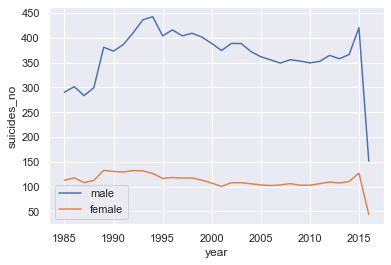

In [11]:
# Lets check what is the difference in suicide rates between men and women

men = df[df['sex'] == 'male']
women = df[df['sex'] == 'female']
sns.lineplot(men.year,men.suicides_no, ci = None);
sns.lineplot(women.year,women.suicides_no, ci = None);
plt.legend(['male','female']);
plt.show()

In any year, suicide numbers for men are almost 3 times higher than for women.

If we look at the graph, both women and men have a very similar shape during the years, having peaks at the same time.
***

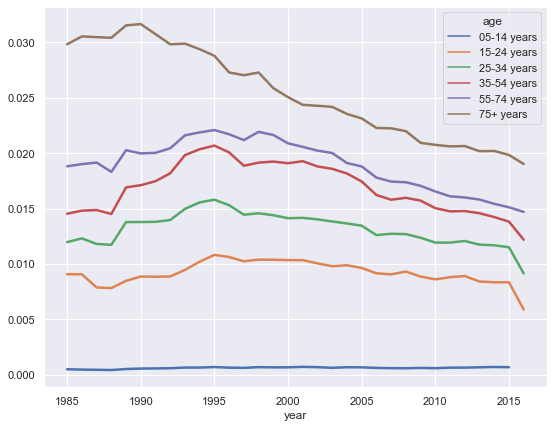

In [12]:
## Lets see if theres is any difference taking into account the age 

df_age = df.groupby(["year","age"])["suicides_no", "population"].sum()
df_reset = df_age.copy().reset_index()
plt.figure(figsize=(9,7))
sns.lineplot("year", df_reset.suicides_no*100/df_reset.population, hue = "age",
             data = df_reset, linewidth = 2.5, style = "age"
            , dashes=False)
plt.show()

Indeed if we look at the age, it follows a very linear behaviour, the suicide rate gets higher when the age is highter. So we can conclude that age as factor for suicide
***

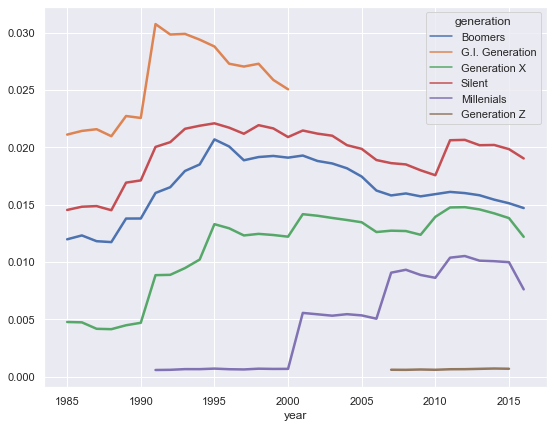

In [13]:
## Now lets check if there is any diffence on suicide rates taking in count the generation

df_age = df.groupby(["year","generation"])["suicides_no", "population"].sum()
df_reset = df_age.copy().reset_index()
plt.figure(figsize=(9,7))
sns.lineplot("year", df_reset.suicides_no*100/df_reset.population, hue = "generation",
             data = df_reset, linewidth = 2.5, style = "generation"
            , dashes=False)
plt.show()


We can see that in Generation X and Millenials, the suicide ratio, even in a low pace, is increasing. The higher rates of suicide are in the G.I Generation. This same generation has suffered with war and the great depression, which can explain the higher rates till 2000. After 2000 we can see a high rate in the Silent generation, which could probably be related to the effects of the WW2 but also its not as high as we can see on the G.I Generation.
***


In [14]:
#Lets take a look at the suicidade rate all over the world

df1 = df.groupby("country")['suicides_no'].sum()
country_name = list(df1.index.get_level_values(0))

In [15]:
#Using pycountry so we can get the the alias cor every country name

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

In [16]:
#See if there is any country missing in our list. 
#Remembering that we used pycountry to get the country names and 

unlisted_country = [i for i in country_name[:] if i not in countries.keys()]
unlisted_country

['Czech Republic',
 'Macau',
 'Republic of Korea',
 'Saint Vincent and Grenadines']

In [17]:
#Couple of names differ, so we gonna change then on our dataset
df.replace("Republic of Korea", "Korea, Republic of", inplace = True)
df.replace('Czech Republic', "Czechia", inplace = True)
df.replace('Macau', 'Macao', inplace = True)
df.replace('Saint Vincent and Grenadines', "Saint Vincent and the Grenadines", inplace = True)

In [18]:
#Now we are going to sumarize the suicide rates for each country and latter on, summarize the it in two columns, 
#one for the country and one for the mean of the suicidade rates of each country
df_suino = df.groupby(["country","year"])["suicides_no"].sum()
df_sum = df_suino.sort_index(ascending=True)[:] * 100

df_pop = df.groupby(["country","year"]).population.sum()
df_pop_sum = df_pop.sort_index(ascending=False)[:]

df_total = df_sum / df_pop_sum

country_dict={}
for country in df_total.index.get_level_values(0):
    if country not in country_dict.keys():
        country_dict[country] = df_total[country].mean()
    else:
        pass

tup = list(country_dict.items())
tup.sort(key= lambda pair:pair[1], reverse = True)

country_list = [a[0] for a in tup]
country_suicide = [a[1] for a in tup]


In [19]:
#We can use Geopandas to get a couple of informations of the countries
#These informations are going to help further, to analize Latim America scenario and also the top 10

country_dict = dict()
for idx in range(len(country_list)):
    country_dict[countries[country_list[idx]]] = country_suicide[idx]

new_country_dict = {}
new_country_dict["iso_a3"] = list(country_dict.keys())
new_country_dict["suicide_rate"] = list(country_dict.values())
country_df = pd.DataFrame(new_country_dict)
country_df.head()

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))
world_df = pd.merge(world, country_df, on = "iso_a3")


In [37]:
world_df

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,suicide_rate
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.003708
1,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.013131
2,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.012835
3,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",0.027041
4,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",0.007232
...,...,...,...,...,...,...,...
76,1221549,Asia,Cyprus,CYP,29260.0,"POLYGON ((32.73178 35.14003, 32.91957 35.08783...",0.003558
77,3856181,Europe,Bosnia and Herz.,BIH,42530.0,"POLYGON ((18.56000 42.65000, 17.67492 43.02856...",0.004351
78,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",0.019142
79,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",0.008026


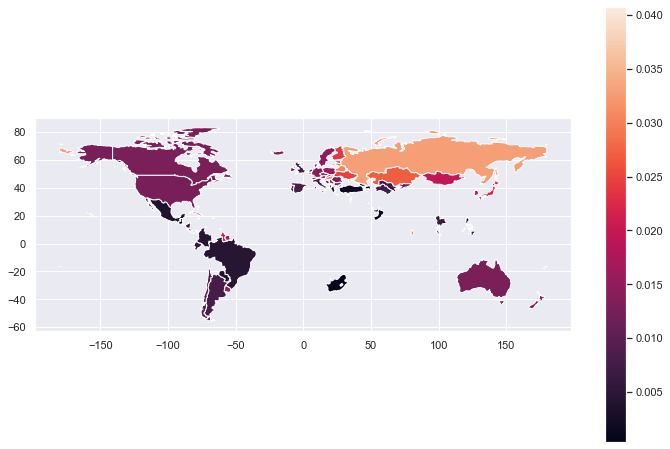

In [58]:
world_df.plot(figsize=(12,8),column='suicide_rate',legend=True);

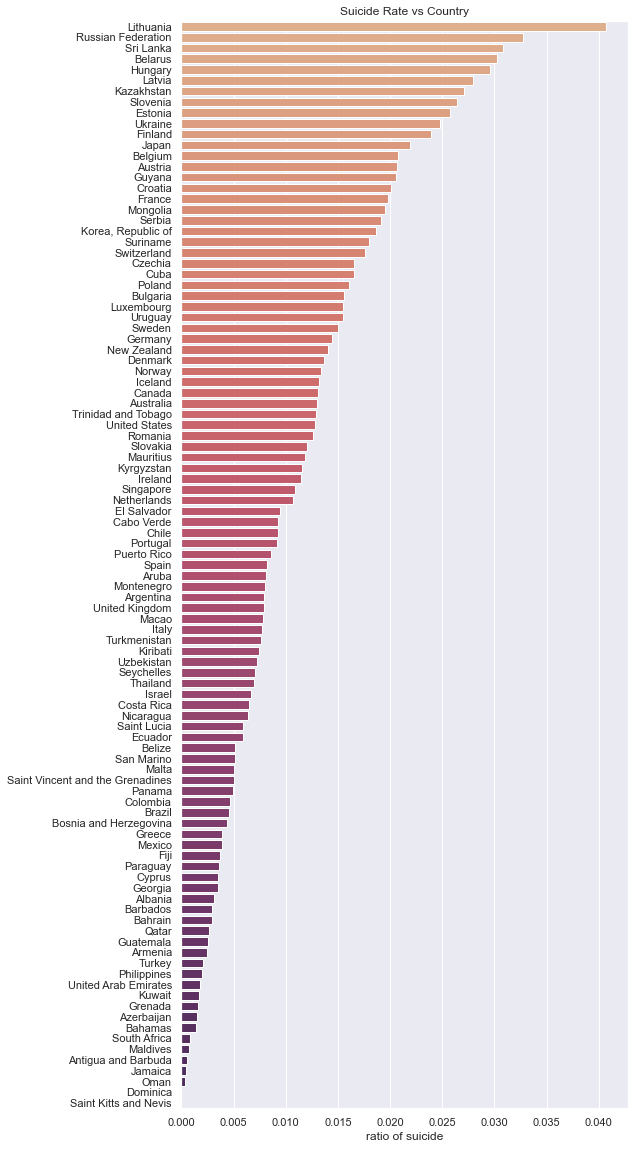

In [234]:
plt.figure(figsize=(8,20))
sns.barplot(x=country_suicide[:],y=country_list[:], palette="flare")
plt.xlabel("ratio of suicide")
plt.title("Suicide Rate vs Country")
plt.show()

That's very curious, if we look at the top 10 countries and also looking at the world map, a great parte of the high suicide rates comes from Eastern Europe, Indeed we can see that the higher rates are very concentrated on this area.

Also, we have a couple countries such as France, Japan, Korea and Austria, tava have high rates of suicide, why such countries with such a developed economy and high HDI have a high suicide rate?

__That moves us to our next question, is the gdp and suicide rates inversely proportional?__

***


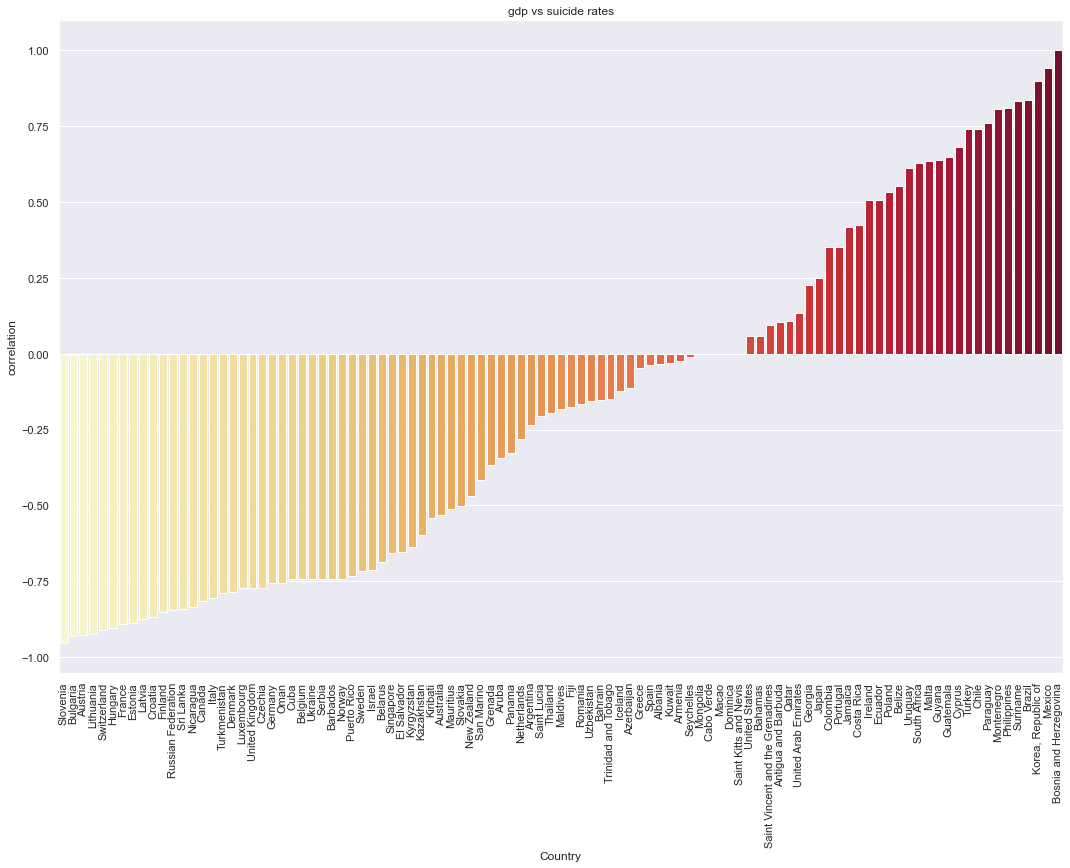

In [29]:
# Running our Person Correlation Coefficient so we can get the correlation between gdp Percapita and Suicide Rates

df_gdp = df.groupby(["country","year"]).gdp_per_capita.mean()
corr_eff = {}
p_value_eff = {}
for country in country_list[:]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values, df_total[country].values)
    corr_eff[country] = float(r_value)
    p_value_eff[country] = float(p_value)

gdp_tup = list(corr_eff.items())
gdp_tup.sort(key= lambda pair:pair[1], reverse = False)
dgp_relation = {a[0]:a[1] for a in gdp_tup}

plt.figure(figsize=(18,12))
sns.barplot(x=list(dgp_relation.keys()), y=list(dgp_relation.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("correlation")
plt.title("gdp vs suicide rates")
plt.show()

With we look at the correlation, we can see that in a lot of the countries, the suicide rates are negatively related to the GDP Percapita. But also, in a couple of countries we can see that it's highly related.

Let's go back to the top 20 countries.
***


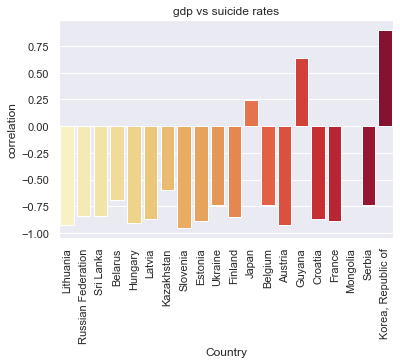

In [28]:

corr_eff = {}
for country in country_list[:20]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values,df_total[country].values)
    corr_eff[country] = float(r_value)
    
sns.barplot(x=list(corr_eff.keys()), y=list(corr_eff.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("correlation")
plt.title("gdp vs suicide rates")
plt.show()

In the top 20 we can see a high correlation between gdp and suicide rate, actually, if we look at the top 10, all of them have a high correlation between the two factors.

Also we have Japan, Korea and Guyana, which have a high gdp but also have higher suicidade rates. We cannot use the data we have available to confirme that, but Japan and Korea are countries with culture of high individual pressure, also exposing individuals that failed as a scum of society. Japan and Korea have a high old age people population.
***

In [74]:
# Get the countries that are from South America and their respective name/suicide rate
latim_america_df = world_df.loc[world_df['continent'] == 'South America']

#Sort our countries by suicide_rate to get a better visualization
latim_america_df_sorted = latim_america_df.sort_values(by=['suicide_rate'],ascending = False)

#The columns we want to plot
latim_america_countries = latim_america_df_sorted['name']
latim_america_suicide = latim_america_df_sorted['suicide_rate']


In [77]:
# Lets get the median of suicide rates around the world to compare with suicide rates in latim america

world_suicide_rate_mean = np.median(country_suicide)
world_suicide_rate_mean

0.008164114689468222

In [78]:
# Do the same step but just using the median of South America
southamerica_suicide_rate_mean = np.median(latim_america_suicide)
southamerica_suicide_rate_mean

0.007910779667076647

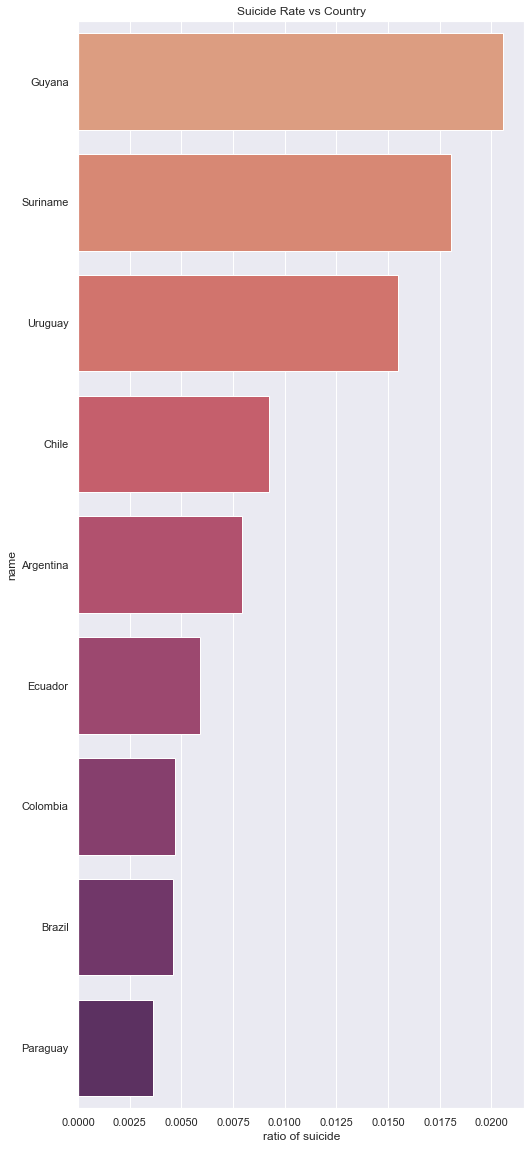

In [75]:
plt.figure(figsize=(8,20))
sns.barplot(x=latim_america_suicide[:],y=latim_america_countries[:], palette="flare")
plt.xlabel("ratio of suicide")
plt.title("Suicide Rate vs Country")
plt.show()

In general, the suicide rates in South America are slightly lower than the global rate. But also in this group we can look at the top 5 countries in South America, which is slighly higher than the global mean.
***

## <font color=green>Conclusion</font>

In conclusion we can see that Age an Sex are two main factors for suicide rates. Also de GDP can be considered in this count, as we could see, the GDP was highly related on the top 20 countries.

The top 10 countries also were ex-countries of the Old Sovietic Union. The higher rates on suicide are related with the GDP, that could be caused by the supression of the government on the financial freedom of the population.

Some countries such as Japan, Korea and France with a high HDI and also considered rich countries have a high suicide rate, that can be caused by other factors that this analysis can't cover, but we can take in count factors such as social pressure, how elder people are treated at this countries and some other cultures factors.

Especially in new generations, the sucide rates are growing in a low pace, but somehow growing. Nothing compared with old generations that were impacted by war and big depressions.

In South America, the suicide rates are slightly lower, also with a low correlation on GDP. Again, with the the data available we cannot extend our analysis.

***
